In [1]:
import pandas as pd
import numpy as np
from dateutil.parser import parse
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.ticker as ticker
import seaborn as sns
import plotly.express as px
from scipy.optimize import curve_fit
import math
from scipy.interpolate import splrep, BSpline
from statsmodels.tsa.seasonal import STL
from sklearn.metrics import mean_squared_error
import ruptures as rpt
import warnings
warnings.simplefilter('ignore')
import sys
sys.path.insert(0,'/Users/Kathy/Desktop/UW/seaflow/decomposition_project/scripts/')
from diel_tools import *
from fig_tools import *
from tsd_functions import *
from rate_functions import *
from simulation_tools import *

In [242]:
import pycmap
api = pycmap.API(token='ec600c40-bb53-11ec-9220-c1bedea45ab3')
# types of data to download from CMAP
all_tbls=['tblGradients4_TN397_14C_NPP_DailyOnDeck','tblKOK1606_Gradients1_14C_NPP',
          'tblKM1513_HOE_legacy_2A_14C_NPP','tblMGL1704_Gradients2_14C_NPP','tblHOT_PP_v20`22']
o2_ar=['tblKOK1606_Gradients1_Surface_O2Ar_NCP','tblMGL1704_Gradients2_Surface_O2Ar_NCP',
       'tblKM1906_Gradients3_Surface_O2Ar_NCP']
group_tbl='tblHOT242_252_14C_PP_WSW_group_sort'
NPP_dfs=[]
# NCP_dfs=[]
# grab group specifc first
for tbl in all_tbls:
    print(tbl)
#     get dataset and add data info
    df=api.get_dataset(tbl)
    df['dataset']=tbl
    # clean up time
    df['time']=pd.DatetimeIndex(df['time']).tz_localize('UTC')
    NPP_dfs.append(df)
#     # get o2 ar dataset and add data info
#     ncp=api.get_dataset(o2_tbl)
#     ncp['dataset']=o2_tbl
#     ncp['time']=pd.DatetimeIndex(ncp['time']).tz_localize('UTC')
#     NCP_dfs.append(ncp)

tblGradients4_TN397_14C_NPP_DailyOnDeck
tblKOK1606_Gradients1_14C_NPP
tblKM1513_HOE_legacy_2A_14C_NPP
tblMGL1704_Gradients2_14C_NPP
tblHOT_PP_v20`22


SystemExit: Invalid table name (tblHOT_PP_v20`22).
Please make sure that the dataset is still available in the CMAP catalog (not deprecated).

In [202]:
## read in TSD model estimations
all_rates=pd.read_pickle('data/all_seaflow_rates_mixed.pickle')
all_tsd=pd.read_pickle('data/all_seaflow_tsd_mixed.pickle')
## do some cleaning
# bin lat values
all_rates['round_lat']=0.5 * round(all_rates['lat']/0.5)
# all_rates['round_lat']=round(all_rates['lat'])

## Group specific data
- No seaflow data for when group experiment was conducted, but just plot over all HOT cruise data

In [209]:
# grab hot cruises from Annette's dataset 
annette_df=pd.read_csv('data/SeaFlow_ALOHA_growth_productivity.csv')
hot_ids=pd.unique(annette_df['cruise'])
# subset hot cruises from here
hot_cruises=all_rates.loc[all_rates['cruise'].isin(hot_ids)]
hot_cruises['time']=pd.DatetimeIndex(hot_cruises['time']).tz_localize('UTC')
# grab just the months
hot_cruises['month']=hot_cruises['time'].dt.month

## load group specific data from 2012
old_hot=api.get_dataset('tblHOT242_252_14C_PP_WSW_group_sort')
# resolve time and get months
old_hot['time']=pd.to_datetime(old_hot['time'])
old_hot['month']=old_hot['time'].dt.month
# only get surface samples
surface=old_hot.loc[old_hot['depth']<=25]
# melt df
cols=['month','C14_assimilation_prochlorococcus',
        'C14_assimilation_synechococcus','C14_assimilation_pico']
surface=surface[cols]
surface.rename(columns={cols[1]:'pro', cols[2]: 'syn', cols[3]: 'picoeuks'}, inplace=True)
surface_long=pd.melt(surface, id_vars=['month'], var_name='pop',value_name='C14_assimilation')
# convert µmol to g (molar mass=18.035 g/mol according to NIH)
surface_long['C14_assimilation_ug']=surface_long['C14_assimilation']*18.035

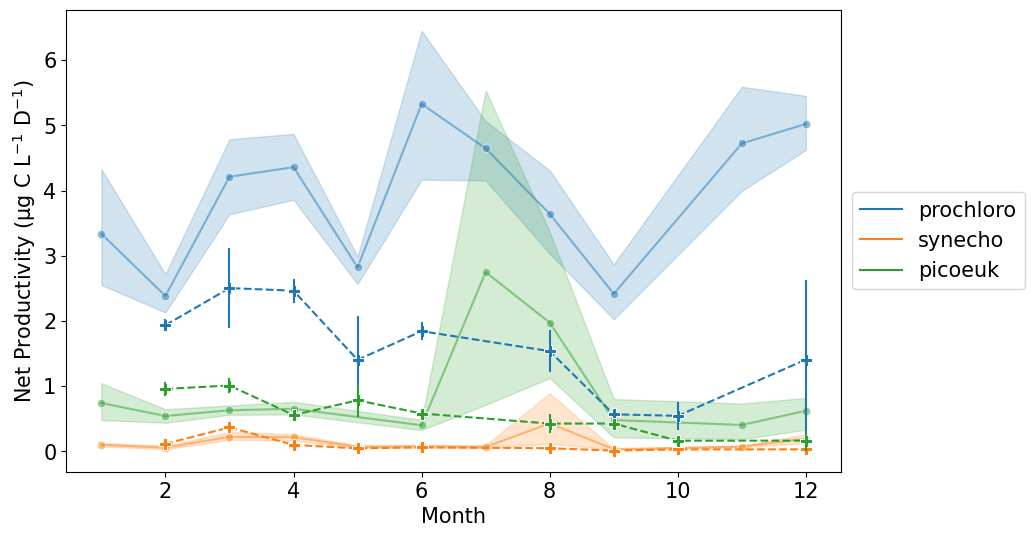

In [224]:
fig,axs=plt.subplots(figsize=(10,6))
hot_cruises['pop_order'] = pd.Categorical(hot_cruises['pop'], categories=['prochloro', 'synecho', 'picoeuk'])
sns.lineplot(data=hot_cruises, x='month',y='productivity', hue='pop_order',ax=axs, marker='o', 
             alpha=0.5, errorbar='ci')
sns.lineplot(data=surface_long, x='month',y='C14_assimilation_ug',hue='pop', 
             marker='P', markersize=8,linestyle='--',err_style='bars', ax=axs, legend=False)
axs.set_ylabel('Net Productivity (µg C $\mathregular{L^{-1}}$ $\mathregular{D^{-1}}$)')
axs.set_xlabel('Month')
axs.legend(loc='center left', bbox_to_anchor=(1, 0.5))

### HOT Data

In [597]:
# HOT_all=NPP_dfs[4]
# ## data cleaning
# ## fix time
# HOT_all['time']=pd.DatetimeIndex(HOT_all['time']).tz_convert('UTC')
# # save exact time and round to days
# HOT_all['exact_time']=HOT_all['time']
# HOT_all['time']=HOT_all['time'].dt.round('1d')
# HOT_all['month']=HOT_all['time'].dt.month
# # filter out for light incubations
# HOT_surface=HOT_all.loc[(HOT_all['l12'].notnull())&(HOT_all['depth']<15)]
## merge with tsd data
# get just picophytoplankton totals
pico_prod=hot_cruises.groupby(['time','month','pop']).sum().reset_index()
monthly_hot_tsd=pico_prod.groupby(['month', 'pop']).agg({
    'productivity':['mean','std']
})
# fix columns
monthly_hot_tsd.columns=['_'.join(col).strip() for col in monthly_hot_tsd.columns.values]
monthly_hot_tsd=monthly_hot_tsd.reset_index()
# get monthly HOT PP values
monthly_hot_PP=HOT_surface.groupby(['month']).agg({
    'l12':['mean','std']
})
# fix columns
monthly_hot_PP.columns=['_'.join(col).strip() for col in monthly_hot_PP.columns.values]
monthly_hot_PP=monthly_hot_PP.reset_index()

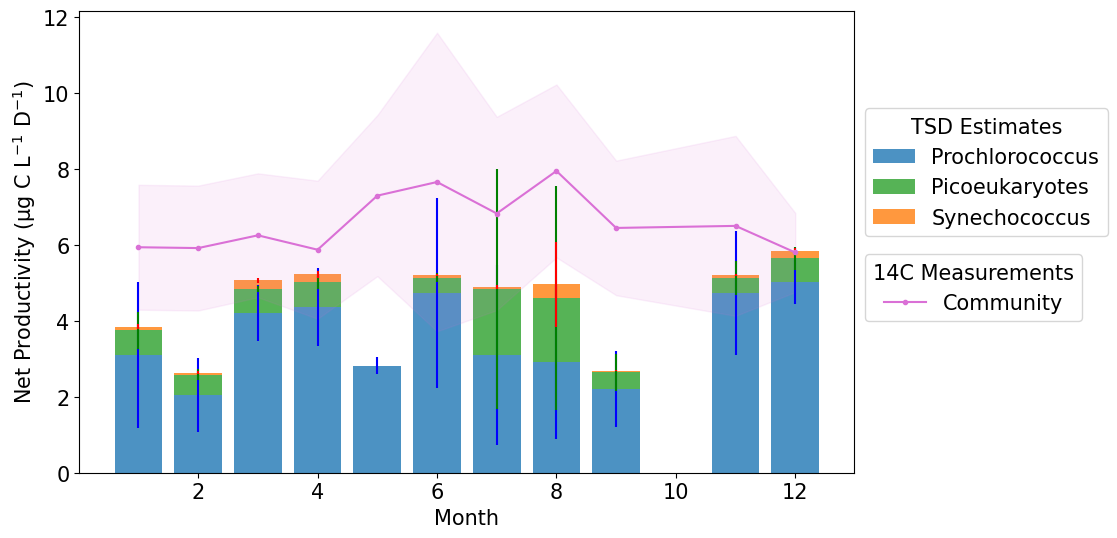

In [616]:
# convert tsd from long to wide
monthly_tsd_wide=monthly_hot_tsd.pivot(index='month',columns='pop')
monthly_tsd_wide.columns=['_'.join(col).strip() for col in monthly_tsd_wide.columns.values]
monthly_tsd_wide=monthly_tsd_wide.reset_index()

fig,axs=plt.subplots(figsize=(10,6))

# # plot monthly community and picophytoplankton NPP
## picophytoplankton
#### make stacked bar plot ####
# create data
x=monthly_tsd_wide['month']
pro = monthly_tsd_wide['productivity_mean_prochloro']
syn = monthly_tsd_wide['productivity_mean_synecho']
picoeuk = monthly_tsd_wide['productivity_mean_picoeuk']

## plot stacked bar plots of TSD estimated Picoeukaryotes
bar1=axs.bar(x, pro, label='Prochlorococcus',
        yerr=monthly_tsd_wide['productivity_std_prochloro'], ecolor='blue', alpha=0.8)
# plot picoeuk
bar2=axs.bar(x, picoeuk, bottom=pro, label='Picoeukaryotes',yerr=monthly_tsd_wide['productivity_std_picoeuk'], 
        ecolor='green', color='tab:green', alpha=0.8)
# plot syn
bar3=axs.bar(x, syn, bottom=pro+picoeuk, label='Synechococcus',yerr=monthly_tsd_wide['productivity_std_synecho'], 
        ecolor='red', alpha=0.8)

# set legend for bar plots
lns=[bar1]+[bar2]+[bar3]
labs = [l.get_label() for l in lns]

l1=axs.legend(lns, labs, title='TSD Estimates', loc='center left', bbox_to_anchor=(1,0.65))

# plot community
ln4=axs.plot(merged_monthly['month'], merged_monthly['l12_mean'], marker='.', 
            c='orchid', label='Community')
axs.fill_between(merged_monthly['month'], 
                    merged_monthly['l12_mean']-merged_monthly['l12_std'], 
                    merged_monthly['l12_mean']+merged_monthly['l12_std'], color='orchid',alpha=0.1)
## community
axs.set_ylabel('Net Productivity (µg C $\mathregular{L^{-1}}$ $\mathregular{D^{-1}}$)')
axs.set_xlabel('Month')
# axs.set_ylabel('% Contribution to Primary Productivity')
# get all axis labels
lns=ln4
labs = [l.get_label() for l in lns]
l2=axs.legend(lns, labs, loc='center left', title='14C Measurements', bbox_to_anchor=(1, 0.4))
plt.gca().add_artist(l1)

plt.rcParams.update({'font.size':15})

## Plotting Gradients data

In [712]:
## create function to plot data for each cruise
# inputs: tsd_df=dataframe with all tsd estimated rates, cruise_name=string to subset tsd_df from,
# c14_df=dataframe of 14C estimated rates, cfix_col=string referencing column name of 14C estimated productivity,
# cfix_std_col=string referencing column of 14C standard deviation, single=boolean to indicate whether 
# there is a single or multiple cruises in the given TSD dataframe
def plot_cruise_productivity(tsd_df, cruise_name, c14_df, cfix_col, cfix_std_col, sf_df=None, single=True, 
                             isohaline=None,chl_front=None):
    #### clean up TSD data ####
    if single:
        cruise_tsd=tsd_df.loc[tsd_df['cruise']==cruise_name]
    else:
        cruise_tsd=tsd_df.copy()
    # aggregate g4 TSD data
    tsd_rounded=cruise_tsd.groupby(['round_lat','pop']).agg({
        'daily_growth':['mean','std'],
        'productivity':['mean','std']
    })
    # flatten col names
    tsd_rounded.columns=['_'.join(col).strip() for col in tsd_rounded.columns.values]
    tsd_rounded=tsd_rounded.reset_index()
    # filter out bad productivity values
    tsd_rounded=tsd_rounded.loc[tsd_rounded['productivity_mean']>0]
    # convert from long to wide
    tsd_wide=tsd_rounded.pivot(index='round_lat', columns='pop')
    tsd_wide.columns=['_'.join(col).strip() for col in tsd_wide.columns.values]
    tsd_wide=tsd_wide.reset_index()

    #### make stacked bar plot ####
    # create data
    x=tsd_wide['round_lat']
    pro = tsd_wide['productivity_mean_prochloro']
    syn = tsd_wide['productivity_mean_synecho']
    picoeuk = tsd_wide['productivity_mean_picoeuk']

    fig,axs=plt.subplots(figsize=(10,6))
    ## plot stacked bar plots of TSD estimated Picoeukaryotes
    bar1=axs.bar(x, pro, label='Prochlorococcus',
            yerr=tsd_wide['productivity_std_prochloro'], ecolor='blue', alpha=0.8)
    # plot picoeuk
    bar2=axs.bar(x, picoeuk, bottom=pro, label='Picoeukaryotes',yerr=tsd_wide['productivity_std_picoeuk'], 
            ecolor='green', color='tab:green', alpha=0.8)
    # plot syn
    bar3=axs.bar(x, syn, bottom=pro+picoeuk, label='Synechococcus',yerr=tsd_wide['productivity_std_synecho'], 
            ecolor='red', alpha=0.8)

    # set legend for bar plots
    lns=[bar1]+[bar2]+[bar3]
    labs = [l.get_label() for l in lns]
    l1=axs.legend(lns, labs, title='TSD Estimates', loc='upper right')

    # plot 14C community productivity as lineplot- only plot if not None (g3 special case)
    if c14_df is not None:
        # first sort by latitude
        c14_df=c14_df.sort_values(by='round_lat')
        ln1=axs.plot(c14_df['round_lat'], c14_df[cfix_col], color='orchid', alpha=0.8, 
                 label='Total Community', marker='.')
        if sf_df is not None:
            # sort sf_df by lat
            sf_df=sf_df.sort_values(by='Latitude')
            ln1a=axs.plot(sf_df['Latitude'], sf_df['0.2-2.0 mm'], color='k', linestyle='--',alpha=0.8, 
                     label='Small Size Class (0.2-2mm)', marker='.')
    # only plot if there is an std col provided
    if cfix_std_col is not None:
        ln2=axs.errorbar(c14_df['round_lat'], c14_df[cfix_col], yerr=c14_df[cfix_std_col],
                    fmt='o', c='k', label='Standard Deviation')

        # set legend for community plots
        lns=ln1+[ln2]
        if sf_df is not None:
            lns=ln1+[ln2]+ln1a
    elif sf_df is not None:
        lns=ln1+ln1a
    else: 
        lns=ln1s
    # additional if statement for G3
    if c14_df is not None:
        labs = [l.get_label() for l in lns]
        l2=axs.legend(lns, labs, title='14C Measurements', loc='upper left', bbox_to_anchor=(0.51,0.7))
        # add both legends
        plt.gca().add_artist(l1)
        
    # plot isohaline and chl fronts if not false
    if isohaline is not None:
        axs.axvline(x=isohaline, linestyle='--', c='k')
    if chl_front is not None:
        axs.axvline(x=chl_front, linestyle='--', c='red')

    axs.set_ylim(0,35)
    axs.set_xlabel("Latitude")
    axs.set_ylabel("Primary Productivity (µg C $\mathregular{L^{-1}}$ $\mathregular{d^{-1}}$)")
    plt.show()

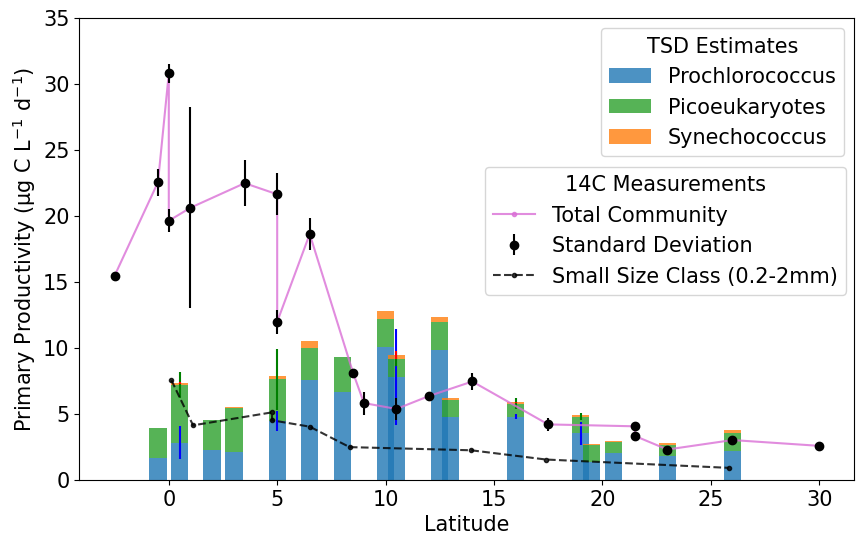

In [713]:
# #### plotting gradients cruises
# ## G1
# ## read in G1 data
# g1_NPP=NPP_dfs[1]
# g1_NPP['exact_time']=g1_NPP['time']
# # add day
# g1_NPP['time']=g1_NPP['time'].dt.round('1d')
# # round latitudes
# g1_NPP['round_lat']=0.5*round(g1_NPP['lat']/0.5)
# # this is in mg/m3 for each day = µg/L/D
# g1_NPP_rounded=g1_NPP[['time','round_lat','PP_24L_D', 'PP_24L_D_stdev_p']]
# g1_NPP_rounded['pop']='community'
# # plot
# iso=32.15
# chl=33.0
# plot_cruise_productivity(all_rates, 'KOK1606', g1_NPP_rounded, 'PP_24L_D', 'PP_24L_D_stdev_p', isohaline=iso,
#                         chl_front=chl)

# ## G2
# g2_NPP=NPP_dfs[3]
# g2_NPP['exact_time']=g2_NPP['time']
# # add day
# g2_NPP['time']=g2_NPP['time'].dt.round('1d')
# # round latitudes by every 1 degree
# g2_NPP['round_lat']=0.5*round(g2_NPP['lat']/0.5)
# # plot
# iso=32.5
# chl=36.2
# plot_cruise_productivity(all_rates, 'MGL1704', g2_NPP_rounded, 'LminusD_24','stdev_24', isohaline=iso, 
#                         chl_front=chl)

## G4
g4_sf=pd.read_csv('data/G4_sf.csv')
g4_NPP=NPP_dfs[0]
g4_NPP['exact_time']=g4_NPP['time']
# add day
g4_NPP['time']=g4_NPP['time'].dt.round('1d')
# round latitudes by every 1 degree
g4_NPP['round_lat']=0.5*round(g4_NPP['lat']/0.5)
# read in SF data
g4_NPP['pop']='community'
# plot
plot_cruise_productivity(all_rates, 'TN397', g4_NPP, 'Cfix','stdev_Cfix', sf_df=g4_sf)

In [ ]:
### special plotting cases
# plot G3
# iso=32.34
# chl=35
# plot_cruise_productivity(all_rates, 'KM1906', None, None, None, isohaline=None, chl_front=None)
# # read in G5 initial summary
g5_NPP=pd.read_csv('data/G5_14C_init_summary.csv')
g5_NPP['PP']=g5_NPP['> 10 mm']+g5_NPP['2-10 mm']+g5_NPP['0.2-2.0 mm']
g5_NPP['round_lat']=0.5*round(g5_NPP['Latitude']/0.5)
g5_NPP['pop']='community'
plot_cruise_productivity(all_rates, 'TN412', g5_NPP, 'PP', sf_df=g5_NPP,cfix_std_col=None)

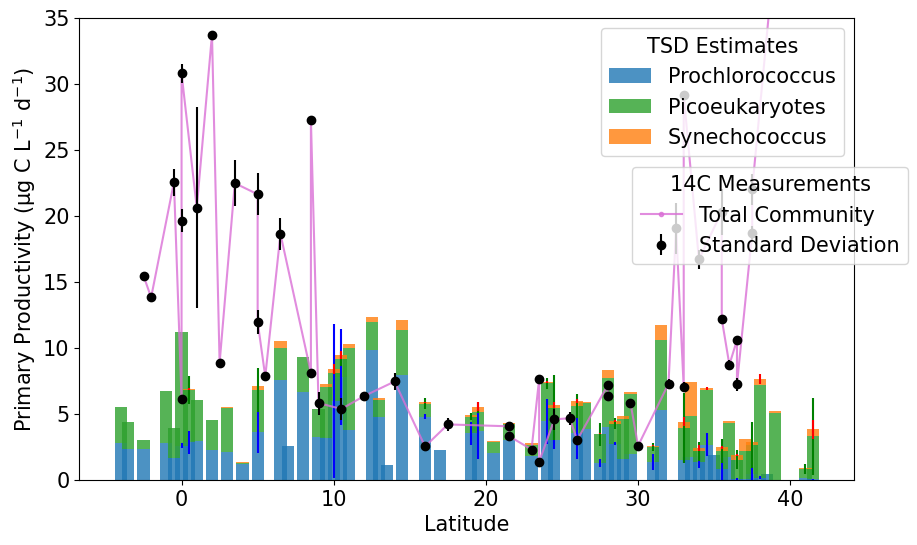

In [679]:
# plot combined gradients cruises
gradients_names=['KOK1606', 'MGL1704', 'KM1906', 'TN397', 'TN412']
gradients_cruises=all_rates.loc[all_rates['cruise'].isin(gradients_names)]
plot_cruise_productivity(gradients_cruises, 'Gradients', all_NPP, 'PP', 'PP_std', single=False)

In [567]:
sum_g1=g1_NPP_rounded[['round_lat','PP_24L_D', 'PP_24L_D_stdev_p']].rename(columns={
    'PP_24L_D':'PP', 'PP_24L_D_stdev_p':'PP_std'})
sum_g2=g2_NPP_rounded[['round_lat','LminusD_24', 'stdev_24']].rename(columns={
    'LminusD_24':'PP', 'stdev_24':'PP_std'})
sum_g4=g4_NPP[['round_lat','Cfix', 'stdev_Cfix']].rename(columns={
    'Cfix':'PP', 'stdev_Cfix':'PP_std'})
sum_g5=g5_NPP[['round_lat','PP']]
all_NPP=pd.concat([sum_g1, sum_g2, sum_g4, sum_g5])

In [319]:
g1_tsd_df=g1_tsd_rounded.reset_index()

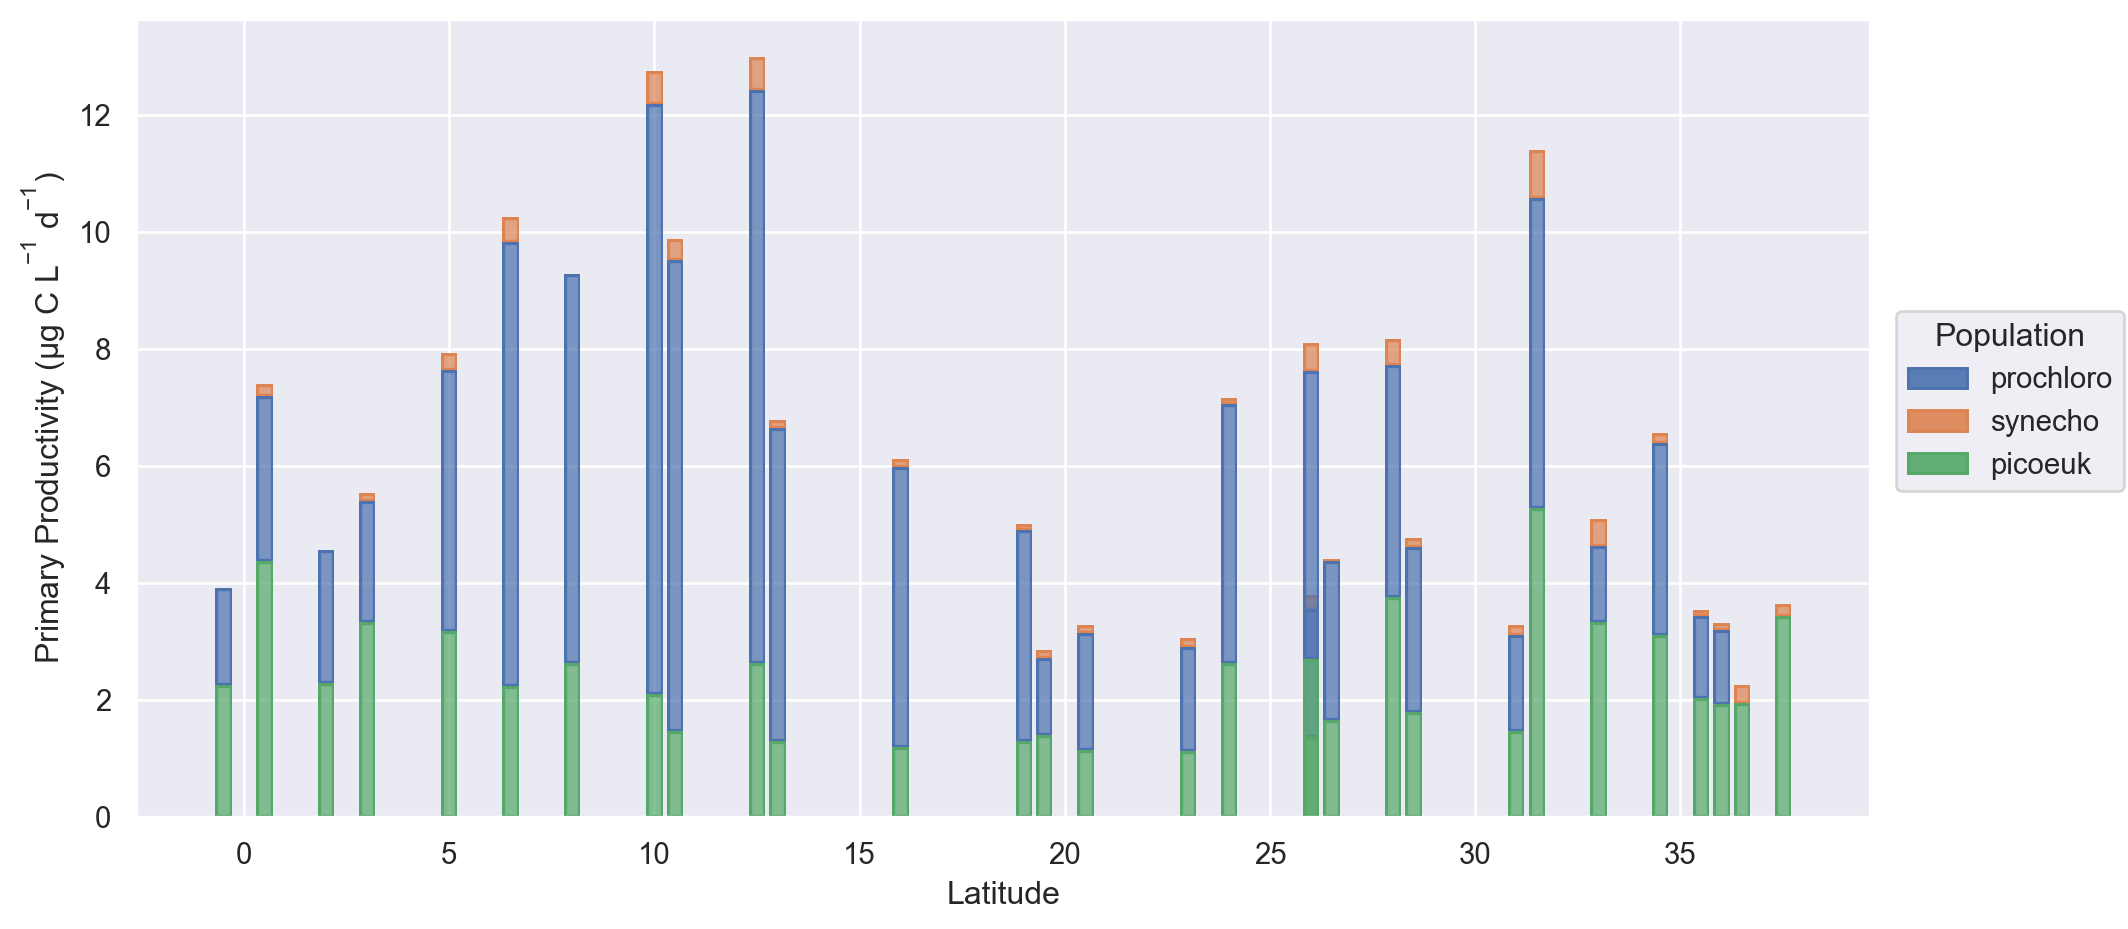

In [320]:
g4_tsd_df['pop_order'] = pd.Categorical(g4_tsd_df['pop'], 
                                             categories=['prochloro', 'synecho', 'picoeuk'])
g1_tsd_df['pop_order'] = pd.Categorical(g1_tsd_df['pop'], 
                                             categories=['prochloro', 'synecho', 'picoeuk'])
p=(
    so.Plot()
#     .add(so.Bar(), data=g1_NPP_rounded, x='round_lat', y='PP_24L',color='pop')
#     .add(so.Bar(), data=g4_NPP_rounded, x='round_lat', y='Cfix',color='pop')
    .add(so.Bar(), so.Stack(),data=g4_tsd_df, x='round_lat', y='productivity',color='pop_order')
    .add(so.Bar(), so.Stack(), data=g1_tsd_df, x='round_lat', y='productivity',color='pop_order')
).layout(size=(10, 5))
p.label(x="Latitude", y="Primary Productivity (µg C $\mathregular{L^{-1}}$ $\mathregular{d^{-1}}$)", 
        color='Population')

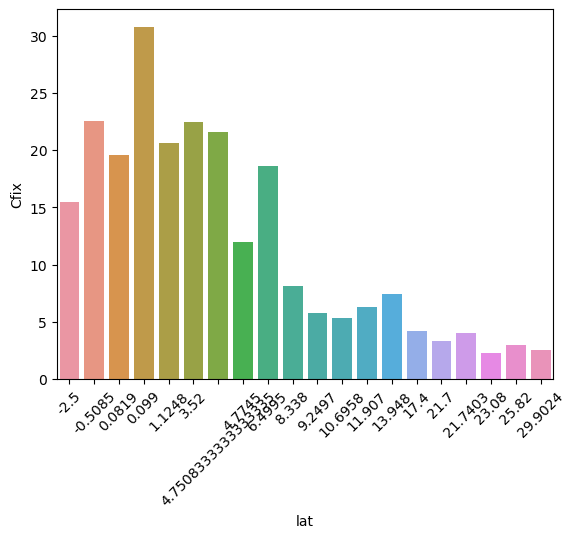

In [48]:
sns.barplot(g4_NPP, x='lat', y='Cfix')
plt.xticks(rotation=45)
plt.show()

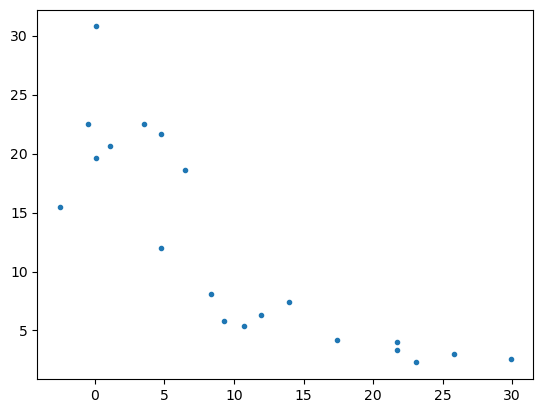

In [35]:
# plot stacked bar plot of g4 data 
plt.plot(g4_NPP['lat'],g4_NPP['Cfix'],marker='.', linestyle='')

## Satellite data

## Dataset from Group-specific picophytoplankton PP (probably gross)
- 14C assimilation: µmol C/L/D
- appears to be monthly averaged
- no seaflow data :( other fcm data?

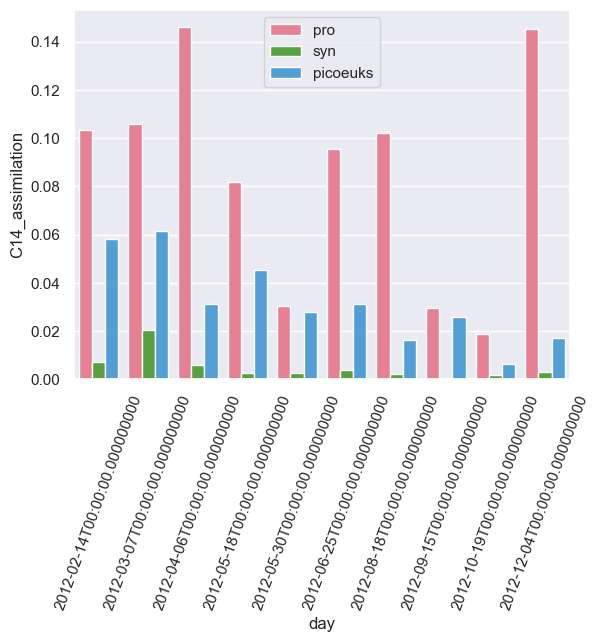

In [21]:
surface=group_df.loc[group_df['depth']<10]
surface['time']=pd.to_datetime(surface['time'])
surface['day']=surface['time'].dt.round("1d")
# melt df
cols=['day','C14_assimilation_prochlorococcus',
        'C14_assimilation_synechococcus','C14_assimilation_pico']
surface_sub=surface[cols]
surface_sub.rename(columns={cols[1]:'pro', cols[2]: 'syn', cols[3]: 'picoeuks'}, inplace=True)
surface_long=pd.melt(surface_sub, id_vars=['day'], var_name='pop',value_name='C14_assimilation')
# plot
sns.set(font_scale=1)
g = sns.barplot(data=surface_long, x='day', y='C14_assimilation', hue='pop',palette='husl')
plt.xticks(rotation=70)
plt.legend()
plt.show()